In [78]:
# Import libraries
import geopandas as gpd
from sqlalchemy import create_engine
import geoalchemy2
import matplotlib.pyplot as plt
import psycopg2
import requests
import json
import overpass
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

In [50]:
# Connect to postgis database
load_dotenv()

DATABASE_URL = os.getenv("DB_URL")
conn = psycopg2.connect(DATABASE_URL)
cursor = conn.cursor()
test_query = 'SELECT * FROM test_table'

# Execute the query
cursor.execute(test_query)

# Fetch and print results
rows = cursor.fetchall()
for row in rows:
    print(row)

# Close the connection
cursor.close()
conn.close()

(1, datetime.datetime(2025, 2, 28, 20, 46, 16, 109652, tzinfo=datetime.timezone.utc))
(2, datetime.datetime(2025, 2, 28, 20, 46, 16, 109652, tzinfo=datetime.timezone.utc))
(3, datetime.datetime(2025, 2, 28, 20, 46, 16, 109652, tzinfo=datetime.timezone.utc))


In [99]:
api = overpass.API()

overpass_query = """
(
  way["highway"="track"](38.50,-109.70,38.70,-109.40);
  way["highway"="path"](38.50,-109.70,38.70,-109.40);
);
out geom;
"""
response = api.get(overpass_query)
print(response)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'type': 'way', 'id': 10104593, 'tags': {'highway': 'track', 'maxspeed': '15 mph', 'oneway': 'no', 'operator': 'Sand Flats Recreation Area', 'surface': 'dirt', 'tracktype': 'grade3'}, 'nodes': [83175624, 83175626, 6419421513, 6419421253, 83175630, 83175631, 8361474776, 83175632, 11347365727, 11347365726, 83175634, 8361474775, 3522643274, 8361474774, 83175636, 11347365725, 8361474773, 83175638, 11347365718, 83175640, 83175642, 8361474772, 3522644629, 3522644625, 83175644, 83175646, 9276164737, 83175648, 83175650, 9276164736, 83175652, 83175654, 83175656, 9276164735, 9276164734, 9276164733, 9276164732, 9276164731, 9276164730, 9276164729, 9276164728, 9276164727, 9276164726, 9276164725, 9276164724, 9276164723, 9276164722, 9276164721, 9276164720, 9276164719, 1556399924]}, 'geometry': {'type': 'LineString', 'coordinates': [[-109.4955523, 38.5821805], [-109.4955651, 38.5823477], [-109.4955421, 38.5824889], [-109.4955

In [100]:
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for feature in response["features"]:
    if "geometry" in feature and feature["geometry"]["type"] == "LineString":
        geojson["features"].append({
            "type": "Feature",
            "geometry": feature["geometry"],
            "properties": feature["properties"]
        })

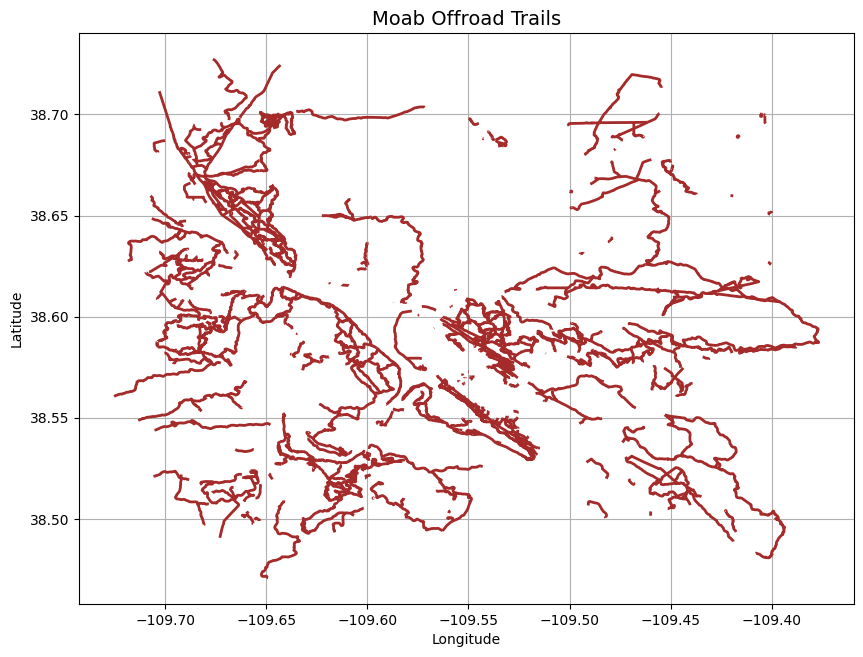

In [101]:
# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson["features"])
gdf = gdf.set_crs("EPSG:26912")
# Plot the trails
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color="brown", linewidth=2)

# Customize the plot
ax.set_title("Moab Offroad Trails", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show()

In [102]:
gdf.head()

,geometry,type,id,tags,nodes
0,"LINESTRING (-109.496 38.582, -109.496 38.582, ...",way,10104593,"{'highway': 'track', 'maxspeed': '15 mph', 'on...","[83175624, 83175626, 6419421513, 6419421253, 8..."
1,"LINESTRING (-109.453 38.575, -109.452 38.574, ...",way,10105121,"{'foot': 'yes', 'highway': 'track', 'horse': '...","[83187556, 83187558, 83187560, 83187562, 93598..."
2,"LINESTRING (-109.402 38.627, -109.402 38.627, ...",way,10105185,"{'access': 'private', 'highway': 'track'}","[83188822, 83188844, 7578864938, 7578864939, 7..."
3,"LINESTRING (-109.493 38.68, -109.493 38.68, -1...",way,10105391,"{'foot': 'yes', 'highway': 'track', 'horse': '...","[8623047389, 8623047388, 8623047387, 862304738..."
4,"LINESTRING (-109.449 38.675, -109.449 38.675, ...",way,10105462,{'highway': 'track'},"[83194481, 83194483, 83194485, 83194487, 83194..."


In [103]:
all_keys = set()
gdf["tags"].dropna().apply(lambda tags: all_keys.update(tags.keys()))

print(all_keys)

{'name', 'tracktype', 'atv', 'oneway', 'alt_name', 'incline', 'covered', 'layer', 'motor_vehicle', '4wd_only', 'operator', 'area', 'informal', 'dirtbike:scale', 'description', 'mtb:scale', 'width', 'maxspeed', 'maintained', 'old_name', 'surface', 'source', 'electric_bicycle', 'bridge', 'smoothness', 'foot', 'official_ref', 'lit', 'note', 'mtb:scale:imba', 'highway', 'pathtype', 'sac_scale', 'motorcycle', 'access', 'name:prefix', 'trail_visibility', 'mtb:scale:amtb', 'safety_rope', 'name:full', 'bicycle', 'ref', 'time', 'horse', 'disused:highway', 'opening_hours'}


In [91]:
# Create new columns with default value None
for key in all_keys:
    gdf[key] = gdf["tags"].apply(lambda tags: tags.get(key) if isinstance(tags, dict) else None)

# Drop the original 'tags' column
gdf = gdf.drop(columns=["tags"])

In [98]:
gdf.head()

,geometry,type,id,nodes,name,tracktype,atv,oneway,alt_name,incline,...,trail_visibility,mtb:scale:amtb,safety_rope,name:full,bicycle,ref,time,horse,disused:highway,opening_hours
0,"LINESTRING (-109.496 38.582, -109.496 38.582, ...",way,10104593,"[83175624, 83175626, 6419421513, 6419421253, 8...",None,grade3,None,no,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"LINESTRING (-109.453 38.575, -109.452 38.574, ...",way,10105121,"[83187556, 83187558, 83187560, 83187562, 93598...",None,grade3,None,None,None,None,...,None,None,None,None,None,None,None,yes,None,None
2,"LINESTRING (-109.402 38.627, -109.402 38.627, ...",way,10105185,"[83188822, 83188844, 7578864938, 7578864939, 7...",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"LINESTRING (-109.493 38.68, -109.493 38.68, -1...",way,10105391,"[8623047389, 8623047388, 8623047387, 862304738...",Dry Mesa,grade3,None,None,None,None,...,None,None,None,None,None,None,None,yes,None,None
4,"LINESTRING (-109.449 38.675, -109.449 38.675, ...",way,10105462,"[83194481, 83194483, 83194485, 83194487, 83194...",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [94]:
columns_to_keep = [
    'id', 'name', 'tracktype', 'atv', 'oneway', 'alt_name', 'incline', 'covered',
    'layer', 'motor_vehicle', 'operator', 'area', 'informal', 'description',
    'width', 'maxspeed', 'maintained', 'old_name', 'surface', 'source',
    'electric_bicycle', 'bridge', 'smoothness', 'foot', 'official_ref', 'lit', 'note',
    'highway', 'pathtype', 'sac_scale', 'motorcycle', 'access', 'trail_visibility', 
    'safety_rope', 'bicycle', 'ref', 'time', 'horse', 
    'opening_hours', 'geometry'
]

# Filter the GeoDataFrame to keep only these columns
gdf_filtered = gdf[columns_to_keep]

In [97]:
# Create a connection engine
engine = create_engine(os.getenv("DB_URL"))

gdf_filtered.to_postgis('offroad_trails', engine, if_exists='append', index=False)